# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [12]:
X_train = np.loadtxt("datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [13]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [14]:

# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [15]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [16]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [17]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [18]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [22]:
# Ваш код здесь
print(pca.n_components_)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [25]:
# Ваш код здесь
print(f"{pca.explained_variance_ratio_[0] * 100:.2f}")

50.74


Визуализируйте данные в проекции на первые две главные компоненты.

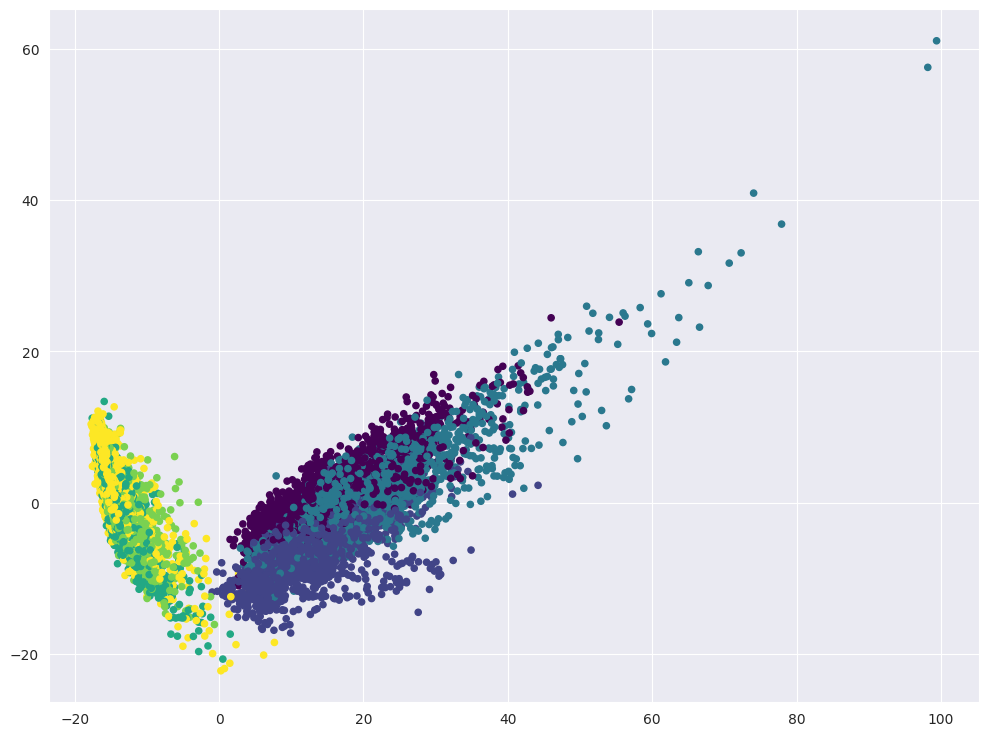

In [27]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [32]:
class MyKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=None, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iterations_ = None

    def _initialize_centroids(self, X):
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices].copy()

    def _calculate_euclidean_distances(self, X, centroids):
        return np.sqrt(((X[:, np.newaxis] - centroids[np.newaxis, :]) ** 2).sum(axis=2))

    def _assign_to_clusters(self, distances):
        return np.argmin(distances, axis=1)

    def _compute_new_centroids(self, X, labels, old_centroids):
        new_centroids = np.zeros_like(old_centroids)
        for cluster_idx in range(self.n_clusters):
            cluster_points = X[labels == cluster_idx]
            if cluster_points.shape[0] > 0:
                new_centroids[cluster_idx] = cluster_points.mean(axis=0)
            else:
                # Если кластер пустой, сохраняем старый центроид
                new_centroids[cluster_idx] = old_centroids[cluster_idx]
        return new_centroids

    def _check_convergence(self, old_centroids, new_centroids):
        return np.all(np.abs(new_centroids - old_centroids) < self.tol)

    def _calculate_total_inertia(self, X, labels, centroids):
        total_inertia = 0.0
        for i in range(len(X)):
            cluster_idx = labels[i]
            total_inertia += np.sum((X[i] - centroids[cluster_idx]) ** 2)
        return total_inertia

    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        best_inertia = float('inf')
        best_centroids = None
        best_labels = None
        best_iterations = 0

        for init_attempt in range(self.n_init):
            current_centroids = self._initialize_centroids(X)
            iteration_count = 0

            for iteration in range(self.max_iter):
                iteration_count += 1
                
                distances_matrix = self._calculate_euclidean_distances(X, current_centroids)
                cluster_assignments = self._assign_to_clusters(distances_matrix)
                
                updated_centroids = self._compute_new_centroids(
                    X, cluster_assignments, current_centroids
                )
                
                if self._check_convergence(current_centroids, updated_centroids):
                    current_centroids = updated_centroids
                    break
                
                current_centroids = updated_centroids

            current_inertia = self._calculate_total_inertia(
                X, cluster_assignments, current_centroids
            )

            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centroids = current_centroids
                best_labels = cluster_assignments
                best_iterations = iteration_count

        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iterations_ = best_iterations

        return self

kmeans_custom = MyKMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE,
    max_iter=300,
    tol=1e-4
)

kmeans_sklearn = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
kmeans_sklearn.fit(X_pca)
cluster_labels_sklearn = kmeans_sklearn.labels_

kmeans_custom.fit(X_pca)
cluster_labels = kmeans_custom.labels_


print(f"Inertia sklearn: {kmeans_sklearn.inertia_:.2f}")
print(f"Inertia custom: {kmeans_custom.inertia_:.2f}")

Inertia sklearn: 2003454.90
Inertia custom: 2003454.20


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

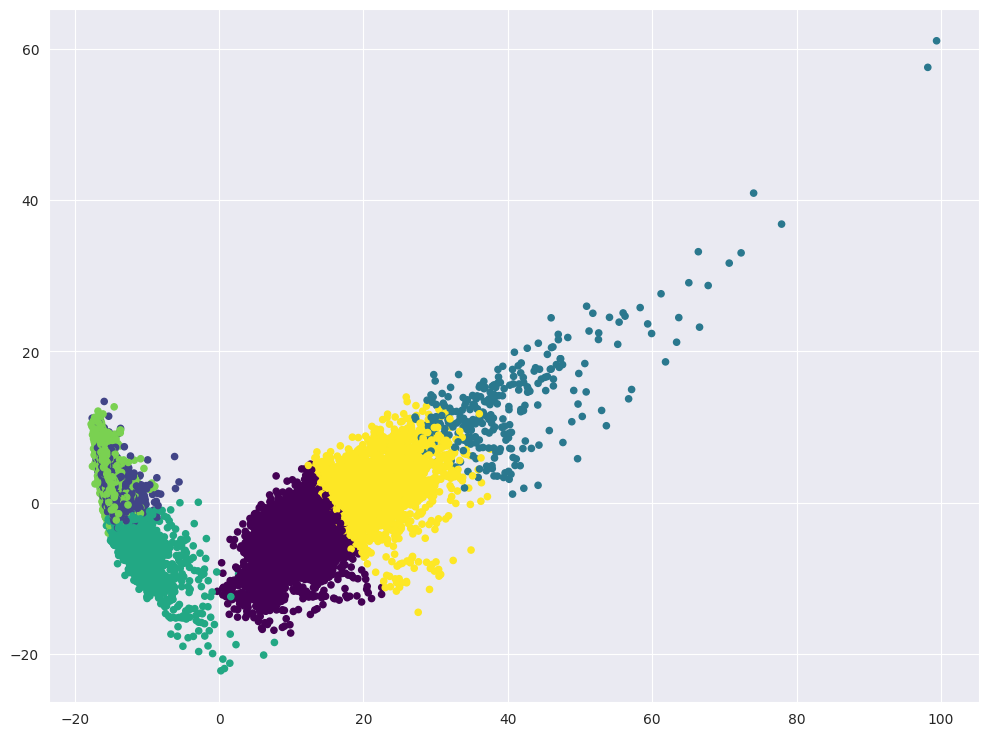

In [33]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [34]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\79057\AppData\Local\Temp\ipykernel_11272\1123513324.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

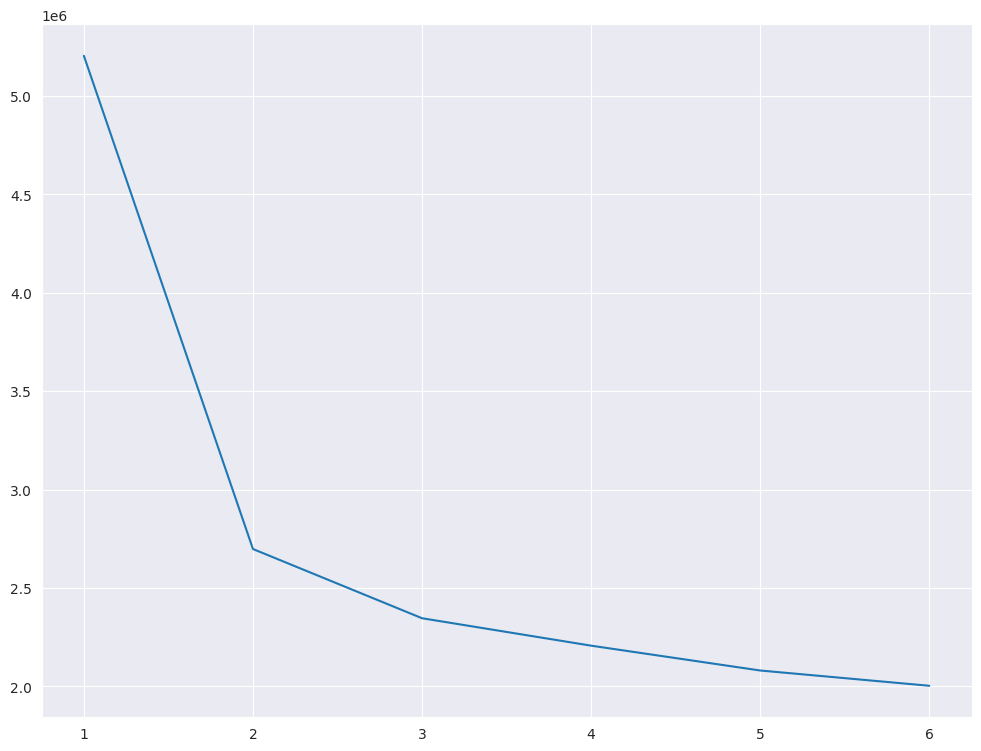

In [35]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, n_classes + 1), inertia)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [36]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [37]:
# Ваш код здесь

ag_score = metrics.adjusted_rand_score(y, ag.labels_)

kmeans_score = metrics.adjusted_rand_score(y, cluster_labels)

print(f"{ag_score:2f} {kmeans_score:2f}")

0.493628 0.419706


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [38]:
# Ваш код здесь
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [40]:
# Ваш код здесь
best_svc = GridSearchCV(svc, svc_params, cv=5)
best_svc.fit(X_train_scaled, y_train)

C:\Users\79057\PycharmProjects\ML\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\79057\PycharmProjects\ML\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\79057\PycharmProjects\ML\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\79057\PycharmProjects\ML\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\79057\PycharmProjects\ML\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [42]:
print(f"Best: {best_svc.best_params_}")

Best: {'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [43]:
y_predicted = best_svc.predict(X_test_scaled)

In [44]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [46]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

grid_search_pca = GridSearchCV(svc, svc_params, cv=3)
grid_search_pca.fit(X_train_pca, y_train)

print(f"Dif {(best_svc.best_score_ - grid_search_pca.best_score_) * 100:.0f}%")

Dif 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

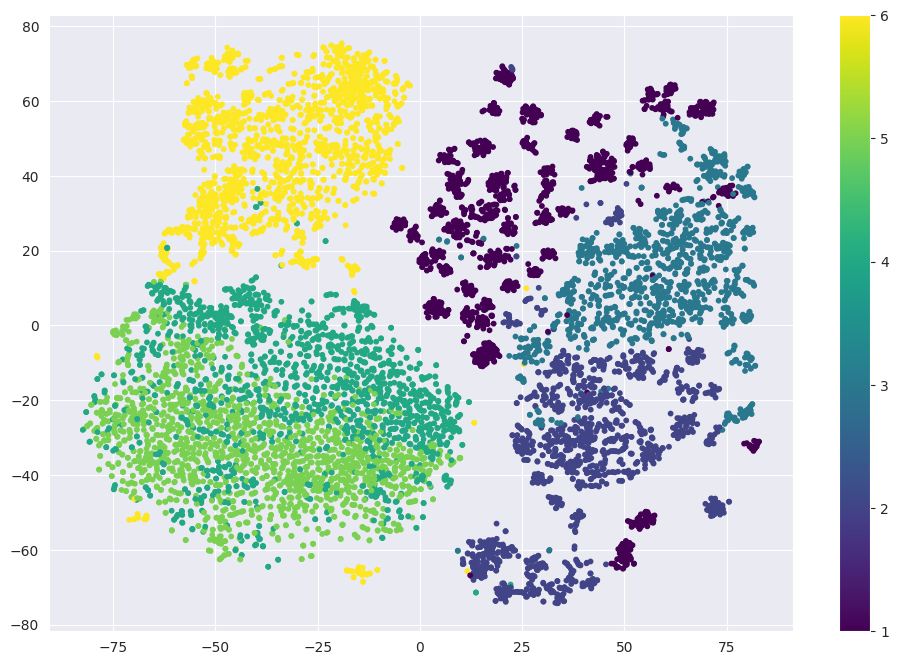

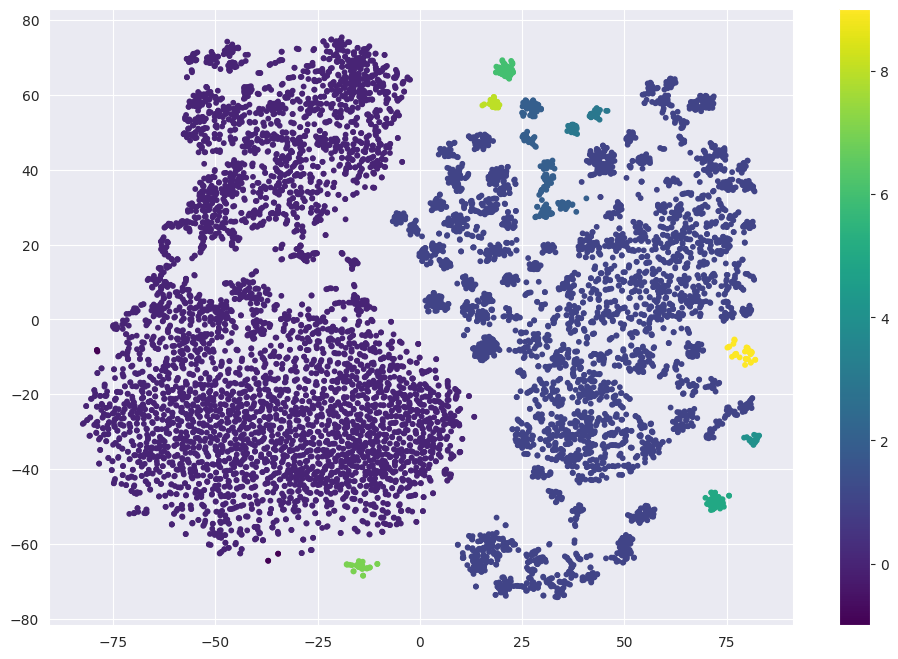

In [50]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=10, cmap='viridis')
plt.colorbar()
plt.show()

dbscan = DBSCAN(eps=5, min_samples=15)
db_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=db_labels, s=10, cmap='viridis')
plt.colorbar()
plt.show()